In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from Bio.SeqIO.FastaIO import SimpleFastaParser
from sklearn.utils import resample
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize, MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier

In [2]:
input_hot_human = '../data/hot_lot_seqs/human/hot_regions_01_all.fa'
input_lot_human = '../data/hot_lot_seqs/human/lot_regions_01_all.fa'
input_hot_worm = '../data/hot_lot_seqs/worm/hot_region_01_all.fa'
input_lot_worm = '../data/hot_lot_seqs/worm/lot_region_01_all.fa'
kmer_length = 4
sampling_percentage = 1
seed = 35

In [3]:
with open(input_hot_human) as fasta_file:
    hot_sequences_human = []
    for title, sequence in SimpleFastaParser(fasta_file):
        if "N" not in sequence:
            hot_sequences_human.append(sequence)

with open(input_lot_human) as fasta_file:
    lot_sequences_human = []
    for title, sequence in SimpleFastaParser(fasta_file):
        if "N" not in sequence:
            lot_sequences_human.append(sequence)

with open(input_hot_worm) as fasta_file:
    hot_sequences_worm = []
    for title, sequence in SimpleFastaParser(fasta_file):
        if "N" not in sequence:
            hot_sequences_worm.append(sequence)

with open(input_lot_worm) as fasta_file:
    lot_sequences_worm = []
    for title, sequence in SimpleFastaParser(fasta_file):
        if "N" not in sequence:
            lot_sequences_worm.append(sequence)

### Create dataset for human and worm with two class label
The following cell creates dataframes for the HOT and LOT sequences with the following labels:
- *1* for HOT sequences (positive class)
- *0* for LOT sequences (negative class)

In [4]:
df_hot = pd.DataFrame(hot_sequences_human, columns=['sequence'])
df_hot['label'] = 1

df_lot = pd.DataFrame(lot_sequences_human, columns=['sequence'])
df_lot['label'] = 0

human_data = pd.concat([df_hot, df_lot])
human_data.label.value_counts()

1    1504
0    1495
Name: label, dtype: int64

In [5]:
df_hot = pd.DataFrame(hot_sequences_worm, columns=['sequence'])
df_hot['label'] = 1

df_lot = pd.DataFrame(lot_sequences_worm, columns=['sequence'])
df_lot['label'] = 0

worm_data = pd.concat([df_hot, df_lot])
worm_data.label.value_counts()

1    20139
0    18792
Name: label, dtype: int64

In [6]:
def seq2kmer_dataset(data, k, scaled= True):
    k = 4
    seq_kmers = []
    for df in range(len(data)):
        seq = data.iloc[df]['sequence']
        kmers = [seq[i:i+k].upper() for i in range(len(seq)-k+1)]
        kmers = ' '.join(kmers)
        seq_kmers.append(kmers)

    labels = data.loc[:,:]['label'].values

    c = CountVectorizer(ngram_range=(1,1))
    x = c.fit_transform(seq_kmers)
    scaler = MaxAbsScaler()
    x_scaled = scaler.fit_transform(normalize(x))
    df_kmer = pd.DataFrame(x.toarray(), columns=c.vocabulary_)
    df_kmer = df_kmer.reindex(sorted(df_kmer.columns), axis=1)

    df_kmer_scaled = pd.DataFrame(x_scaled.toarray(), columns=c.vocabulary_)
    df_kmer_scaled = df_kmer_scaled.reindex(sorted(df_kmer_scaled.columns), axis=1)

    if scaled:
        return df_kmer_scaled, labels
    else:
        return df_kmer, labels


## Settings 1 - Train from human 

In [7]:
X_h, y_h = seq2kmer_dataset(human_data, 4, scaled=True)
X_train_h, X_test_h, Y_train_h, Y_test_h = train_test_split(X_h, y_h, test_size = 0.25, random_state=seed, stratify=y_h)


#### Logistic Regression :

Accuracy = 0.92
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       374
           1       0.93      0.91      0.92       376

    accuracy                           0.92       750
   macro avg       0.92      0.92      0.92       750
weighted avg       0.92      0.92      0.92       750



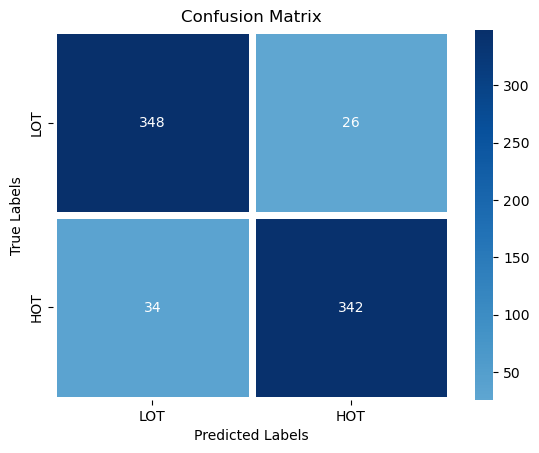

In [8]:


from sklearn.linear_model import LogisticRegression
clf_Lr = LogisticRegression( penalty="l2" )
clf_Lr.fit(X_train_h, Y_train_h)
Y_pred = clf_Lr.predict(X_test_h)
print('Accuracy =', accuracy_score(Y_test_h, Y_pred))

print(classification_report(Y_test_h, Y_pred))

cf = confusion_matrix(Y_test_h, Y_pred)
ax = plt.subplot()
sns.heatmap(cf, annot=True, fmt='d', ax=ax, linewidths=5, cmap="Blues", center=0)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['LOT', 'HOT'])
ax.yaxis.set_ticklabels(['LOT', 'HOT'])
plt.show()


#### Random Forest :

Accuracy = 0.9253333333333333
              precision    recall  f1-score   support

           0       0.92      0.93      0.93       374
           1       0.93      0.92      0.92       376

    accuracy                           0.93       750
   macro avg       0.93      0.93      0.93       750
weighted avg       0.93      0.93      0.93       750



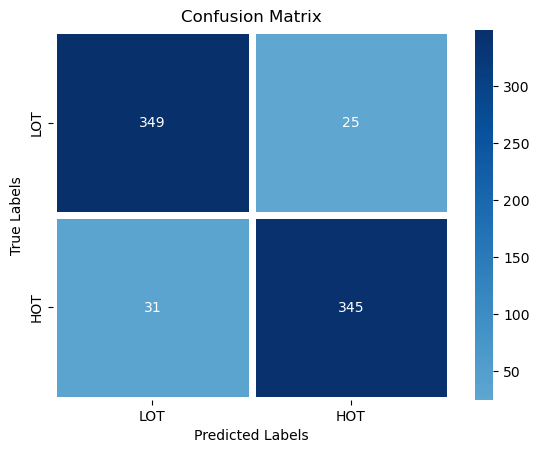

In [12]:

clf_RF = RandomForestClassifier(n_estimators = 100)
clf_RF.fit(X_train_h, Y_train_h)
Y_pred = clf_RF.predict(X_test_h)
print('Accuracy =', accuracy_score(Y_test_h, Y_pred))

print(classification_report(Y_test_h, Y_pred))

cf = confusion_matrix(Y_test_h, Y_pred)
ax = plt.subplot()
sns.heatmap(cf, annot=True, fmt='d', ax=ax, linewidths=5, cmap="Blues", center=0)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['LOT', 'HOT'])
ax.yaxis.set_ticklabels(['LOT', 'HOT'])
plt.show()


## Settings 2 -  Train from worm:

In [13]:
X_w, y_w = seq2kmer_dataset(worm_data, 4, True)

X_train_w, X_test_w, Y_train_w, Y_test_w = train_test_split(X_w, y_w, test_size = 0.25, random_state=seed, stratify=y_w)

#### Logistic Regression :

Accuracy = 0.8224596732764821
              precision    recall  f1-score   support

           0       0.81      0.82      0.82      4698
           1       0.83      0.82      0.83      5035

    accuracy                           0.82      9733
   macro avg       0.82      0.82      0.82      9733
weighted avg       0.82      0.82      0.82      9733



/Users/faisal/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


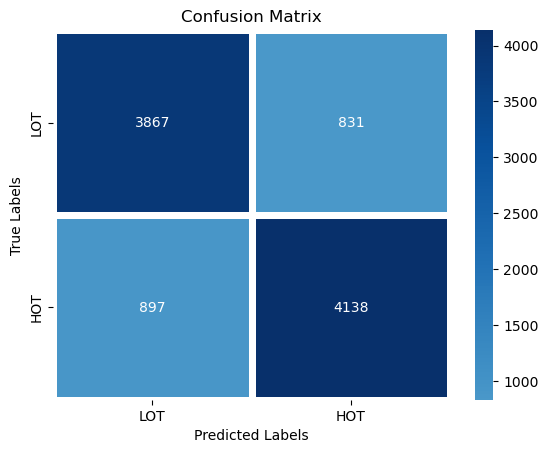

In [14]:


from sklearn.linear_model import LogisticRegression
clf_Lr_w = LogisticRegression( penalty="l2" )
clf_Lr_w.fit(X_train_w, Y_train_w)
Y_pred = clf_Lr_w.predict(X_test_w)
print('Accuracy =', accuracy_score(Y_test_w, Y_pred))

print(classification_report(Y_test_w, Y_pred))

cf = confusion_matrix(Y_test_w, Y_pred)
ax = plt.subplot()
sns.heatmap(cf, annot=True, fmt='d', ax=ax, linewidths=5, cmap="Blues", center=0)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['LOT', 'HOT'])
ax.yaxis.set_ticklabels(['LOT', 'HOT'])
plt.show()

#### Random Forest :

Accuracy = 0.8660228090003083
              precision    recall  f1-score   support

           0       0.87      0.85      0.86      4698
           1       0.86      0.88      0.87      5035

    accuracy                           0.87      9733
   macro avg       0.87      0.87      0.87      9733
weighted avg       0.87      0.87      0.87      9733



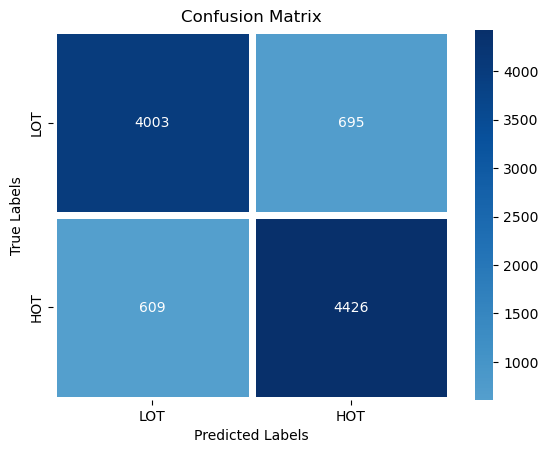

In [15]:

clf_RF_w = RandomForestClassifier(n_estimators = 100)
clf_RF_w.fit(X_train_w, Y_train_w)
Y_pred = clf_RF_w.predict(X_test_w)
print('Accuracy =', accuracy_score(Y_test_w, Y_pred))

print(classification_report(Y_test_w, Y_pred))

cf = confusion_matrix(Y_test_w, Y_pred)
ax = plt.subplot()
sns.heatmap(cf, annot=True, fmt='d', ax=ax, linewidths=5, cmap="Blues", center=0)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['LOT', 'HOT'])
ax.yaxis.set_ticklabels(['LOT', 'HOT'])
plt.show()


## Settings 3 - Train from both human and worm:

In [16]:
Xh, yh = seq2kmer_dataset(human_data, 4, scaled=True)
Xw, yw = seq2kmer_dataset(worm_data, 4, scaled=True)

X_trainh, X_testh, Y_trainh, Y_testh = train_test_split(Xh, yh, test_size = 0.25, random_state=seed, stratify=yh)
X_trainw, X_testw, Y_trainw, Y_testw = train_test_split(Xw, yw, test_size = 0.25, random_state=seed, stratify=yw)

X_train_ = np.concatenate((X_trainh, X_trainw), axis=0)
y_train_ = np.concatenate((Y_trainh, Y_trainw), axis=0)

#### Logistic Regression :

Accuracy for Human = 0.9053333333333333
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       374
           1       0.92      0.89      0.90       376

    accuracy                           0.91       750
   macro avg       0.91      0.91      0.91       750
weighted avg       0.91      0.91      0.91       750



/Users/faisal/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


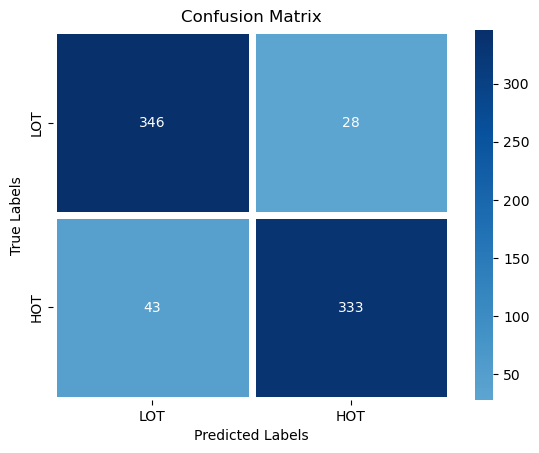

/Users/faisal/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


Accuracy for Worm = 0.8212267543409021
              precision    recall  f1-score   support

           0       0.81      0.82      0.82      4698
           1       0.83      0.82      0.83      5035

    accuracy                           0.82      9733
   macro avg       0.82      0.82      0.82      9733
weighted avg       0.82      0.82      0.82      9733



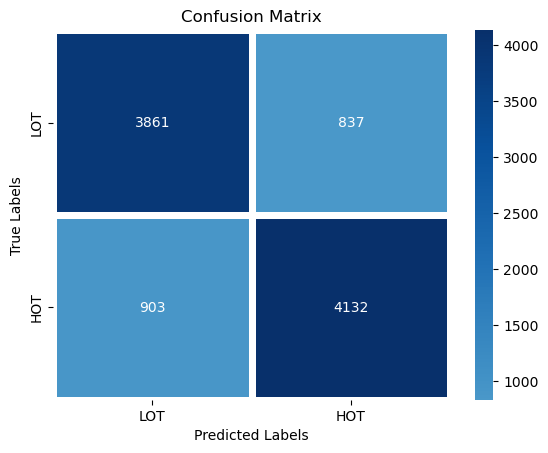

In [17]:

from sklearn.linear_model import LogisticRegression
clf_LR2 = LogisticRegression( penalty="l2", max_iter=1000 )
clf_LR2.fit(X_train_, y_train_)

Y_pred = clf_LR2.predict(X_testh)
print('Accuracy for Human =', accuracy_score(Y_testh, Y_pred))
print(classification_report(Y_testh, Y_pred))
cf = confusion_matrix(Y_testh, Y_pred)
ax = plt.subplot()
sns.heatmap(cf, annot=True, fmt='d', ax=ax, linewidths=5, cmap="Blues", center=0)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['LOT', 'HOT'])
ax.yaxis.set_ticklabels(['LOT', 'HOT'])
plt.show()


Y_pred = clf_LR2.predict(X_testw)
print('Accuracy for Worm =', accuracy_score(Y_testw, Y_pred))
print(classification_report(Y_testw, Y_pred))
cf = confusion_matrix(Y_testw, Y_pred)
ax = plt.subplot()
sns.heatmap(cf, annot=True, fmt='d', ax=ax, linewidths=5, cmap="Blues", center=0)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['LOT', 'HOT'])
ax.yaxis.set_ticklabels(['LOT', 'HOT'])
plt.show()

#### Random Forest :

Accuracy for Human = 0.92
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       374
           1       0.93      0.91      0.92       376

    accuracy                           0.92       750
   macro avg       0.92      0.92      0.92       750
weighted avg       0.92      0.92      0.92       750



/Users/faisal/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


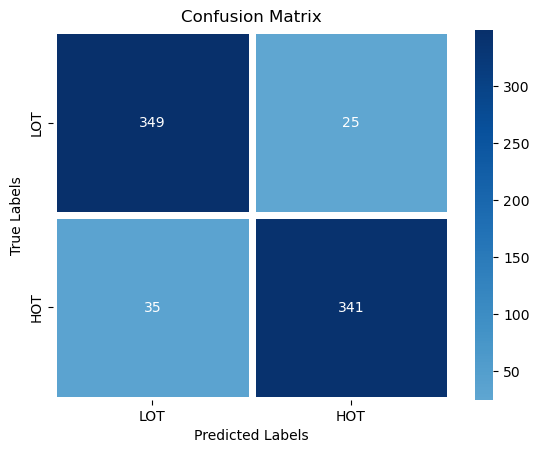

/Users/faisal/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Accuracy for Worm = 0.8655090927771499
              precision    recall  f1-score   support

           0       0.87      0.85      0.86      4698
           1       0.86      0.88      0.87      5035

    accuracy                           0.87      9733
   macro avg       0.87      0.86      0.87      9733
weighted avg       0.87      0.87      0.87      9733



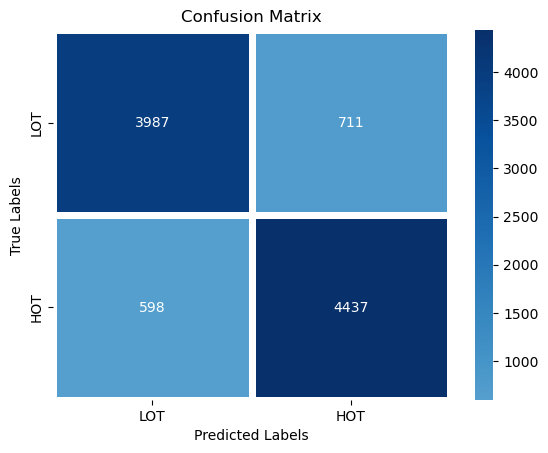

In [18]:

clf_RF2 = RandomForestClassifier(n_estimators = 100)
clf_RF2.fit(X_train_, y_train_)

Y_pred = clf_RF2.predict(X_testh)
print('Accuracy for Human =', accuracy_score(Y_testh, Y_pred))
print(classification_report(Y_testh, Y_pred))
cf = confusion_matrix(Y_testh, Y_pred)
ax = plt.subplot()
sns.heatmap(cf, annot=True, fmt='d', ax=ax, linewidths=5, cmap="Blues", center=0)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['LOT', 'HOT'])
ax.yaxis.set_ticklabels(['LOT', 'HOT'])
plt.show()


Y_pred = clf_RF2.predict(X_testw)
print('Accuracy for Worm =', accuracy_score(Y_testw, Y_pred))
print(classification_report(Y_testw, Y_pred))
cf = confusion_matrix(Y_testw, Y_pred)
ax = plt.subplot()
sns.heatmap(cf, annot=True, fmt='d', ax=ax, linewidths=5, cmap="Blues", center=0)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['LOT', 'HOT'])
ax.yaxis.set_ticklabels(['LOT', 'HOT'])
plt.show()

# Explanation with  SHAP 

How SHAP works and the library is adapted from: https://christophm.github.io/interpretable-ml-book/shap.html 

The following function takes 3 input and return SHAP values for each example in the given dataset. It also plots the summary of SHAP values for the top important features.

<INPUT:>

- clf           :   classifier that needs to be explained
- X             :   dataset (features values for all example)
- top_features  :   top # features according to the importance 

<OUTPUT:>
- shap_values   :   SHAP vaules for each example
- This function plots the summary of SHAP values for the most important features. 
                    In this plot, y axis contains the most important features, and x axis shows the SHAP values. 
                    Every point in the plot is a data point in the dataset representing their SHAP value for the corresponding feature.
                    Colors mean the high and low value of that feature in that data point. 
                    From the color and distribution of SHAP values, we can have an idea of feature values and their positive/negative effect on classification. 
                    Here, feature = k-mers. 

In [19]:
def explain_SHAP(clf, X, top_feature = 20):
    import shap
    explainer = shap.TreeExplainer(clf)
    shap_values = explainer.shap_values(X)
    plt.plot()
    plt.title("Most important features and their effect")
    shap.summary_plot(shap_values[0], X.astype("float"), max_display=top_feature)
    plt.show()
    return shap_values


#### Interpretation - 1: Random Forest learned from Human data

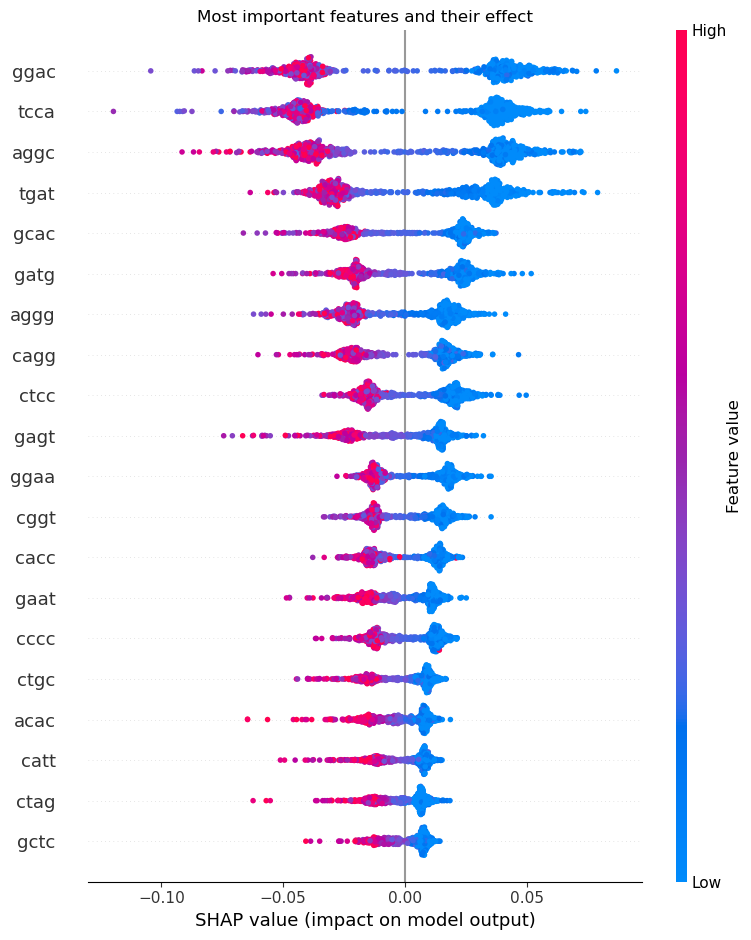

In [20]:
rf_shap = explain_SHAP(clf_RF, X_test_h)

#### Interpretation - 2: Random Forest learned from Worm data

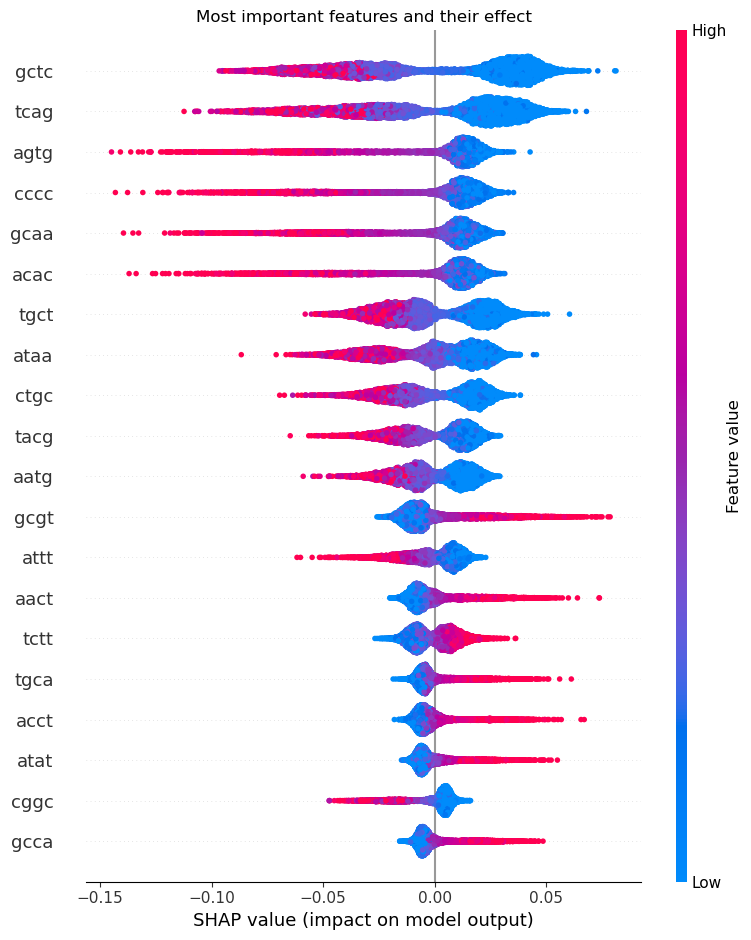

In [21]:
rf_shap_w = explain_SHAP(clf_RF_w, X_test_w)  